# Intro
- Using keorgams of storms and using travelling correlation functions method to find the shift in latitude of edens at time intervals of 10 min
- Using above method to calculated speed of storms

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import cartopy.crs as ccrs
from tqdm import tqdm
import importlib as il
import datetime as dt
from scipy.interpolate import CubicSpline
from scipy.signal import find_peaks, savgol_filter


In [16]:
path = '/home/pxv220016/prasoon/data/sat_interp_repo/repo2/Cesar_LSTID_vel/Cesar_data/'


date = ['20130316', '20130317', '20130318']
data = []

for d in date:
    p = path + 'file' + d + '.dTEC'
    df = pd.read_csv(p, delim_whitespace=True, skiprows=1)
    
    ds = xr.Dataset.from_dataframe(df)
    print(ds)
    data.append(ds)

<xarray.Dataset>
Dimensions:  (index: 86131)
Coordinates:
  * index    (index) int64 0 1 2 3 4 5 6 ... 86125 86126 86127 86128 86129 86130
Data variables:
    lat1     (index) float64 -80.0 -80.0 -80.0 -80.0 ... 62.0 62.0 62.0 62.0
    lat2     (index) float64 -79.5 -79.5 -79.5 -79.5 ... 62.5 62.5 62.5 62.5
    lon1     (index) int64 0 180 360 540 720 ... 75420 75600 75780 75960 76140
    lon2     (index) int64 360 540 720 900 1080 ... 75960 76140 76320 76500
    dtec     (index) int64 23 28 80 28 25 25 11 7 4 ... 79 80 30 80 81 82 81 81
<xarray.Dataset>
Dimensions:  (index: 103063)
Coordinates:
  * index    (index) int64 0 1 2 3 4 5 ... 103058 103059 103060 103061 103062
Data variables:
    lat1     (index) float64 -80.0 -80.0 -80.0 -80.0 ... 62.0 62.0 62.0 62.0
    lat2     (index) float64 -79.5 -79.5 -79.5 -79.5 ... 62.5 62.5 62.5 62.5
    lon1     (index) int64 0 180 360 540 720 ... 75240 75420 75600 75780 75960
    lon2     (index) int64 360 540 720 900 1080 ... 75780 75960 76140 

In [17]:
dates = ['2011-08-06']

for d in dates:
    p = path + d + '.csv'
    df = pd.read_csv(p)
    #print(df['Datetime'][0], type(df['Datetime'][0]))
    df['Datetime'] = pd.to_datetime(df['Datetime'])
    df.set_index('Datetime', inplace = True)
    ds = df.to_xarray()
    print(ds)


<xarray.Dataset>
Dimensions:   (Datetime: 252357)
Coordinates:
  * Datetime  (Datetime) datetime64[ns] 2011-08-05 ... 2011-08-07T23:57:00
Data variables:
    Glat      (Datetime) float64 -44.0 23.5 -29.0 -2.0 ... -25.5 -54.0 -5.5 17.5
    dTEC      (Datetime) float64 -0.3556 -0.3778 -0.4222 ... -0.3778 -0.3333
['2011-08-05T00:00:00.000000000' '2011-08-05T00:00:00.000000000'
 '2011-08-05T00:00:00.000000000' '2011-08-05T00:00:00.000000000'
 '2011-08-05T00:00:00.000000000' '2011-08-05T00:00:00.000000000'
 '2011-08-05T00:00:00.000000000' '2011-08-05T00:00:00.000000000'
 '2011-08-05T00:00:00.000000000' '2011-08-05T00:00:00.000000000']


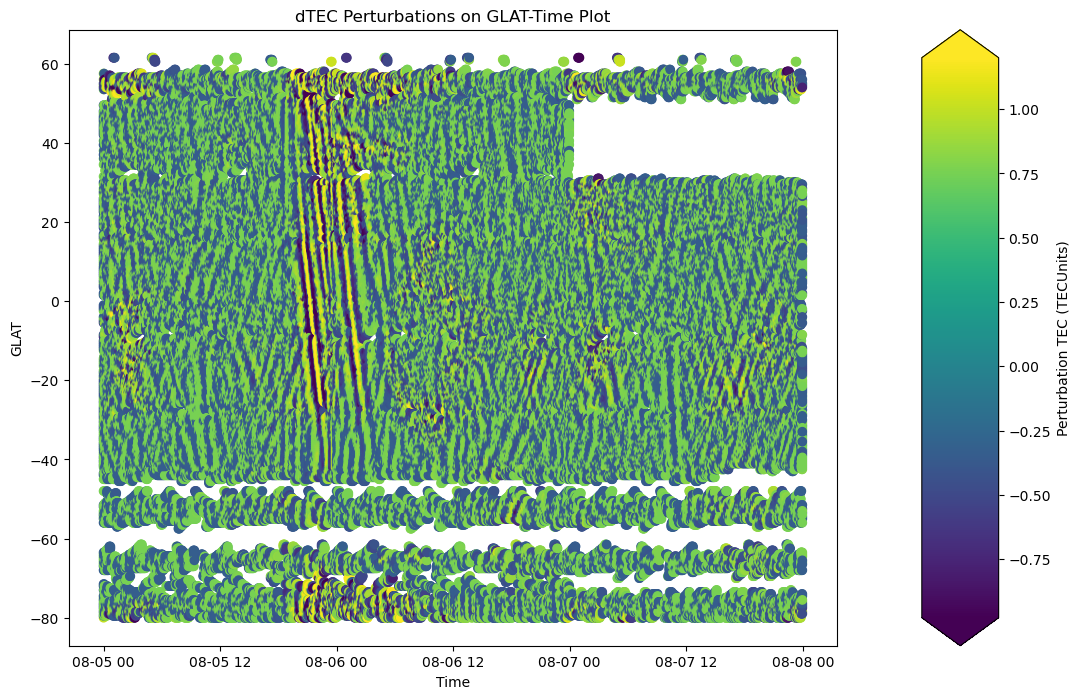

In [4]:
fig = plt.figure(figsize=(12,8))
specs = fig.add_gridspec(1, 2, width_ratios=[1,0.1])
ax = []
ax.append(fig.add_subplot(specs[0, 0]))
c = ax[0].scatter(ds.Datetime.values, ds.Glat.values, c=ds.dTEC.values)
ax[0].set_title('dTEC Perturbations on GLAT-Time Plot')
ax[0].set_ylabel('GLAT')
ax[0].set_xlabel('Time')

cbar_ax = fig.add_subplot(specs[0,1])
cbar = fig.colorbar(c, cax=cbar_ax, label='Perturbation TEC (TECUnits)', extend='both')
fig.show()

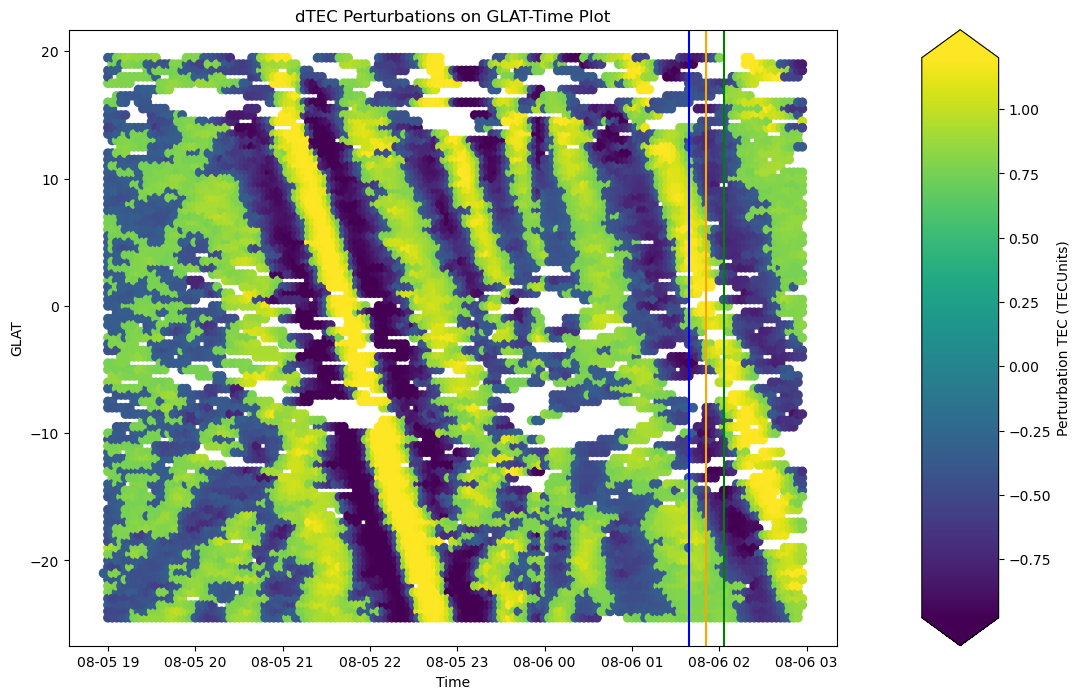

In [12]:
a = 70000
b = 100000

ds_n = ds.isel(Datetime=slice(a,b))

# Limits of latitudes
l1 = -25
l2 = 20
ds_n = ds_n.where((ds_n.Glat > l1), drop=True)
ds_n = ds_n.where((ds_n.Glat < l2), drop=True)

# index to set the time of observations
time1 = 10000
time2 = 10250
time3 = 10500

#mask = [(i > -40 and i < 50) for i in ds_n.Glat.values]

fig = plt.figure(figsize=(12,8))
specs = fig.add_gridspec(1, 2, width_ratios=[1,0.1])
ax = []
ax.append(fig.add_subplot(specs[0, 0]))
ax[0].axvline(x=ds_n.Datetime.values[time1], color='blue')
ax[0].axvline(x=ds_n.Datetime.values[time2], color='orange')
ax[0].axvline(x=ds_n.Datetime.values[time3], color='green')
c = ax[0].scatter(ds_n.Datetime.values, ds_n.Glat.values, c=ds_n.dTEC.values)
ax[0].set_title('dTEC Perturbations on GLAT-Time Plot')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('GLAT')

cbar_ax = fig.add_subplot(specs[0,1])
cbar = fig.colorbar(c, cax=cbar_ax, label='Perturbation TEC (TECUnits)', extend='both')
fig.show()

In [56]:
def smoothen(func, lats):
    y = savgol_filter(func.dTEC.values, 5, 1)
    cs = CubicSpline(func.Glat.values, y)
    y1 = cs(lats)
    df = pd.DataFrame()
    df['Glat'] = lats
    df['dTEC'] = y1

    return df

11816 161
2011-08-06T01:39:00.000000000 2011-08-06T01:51:00.000000000 2011-08-06T02:03:00.000000000


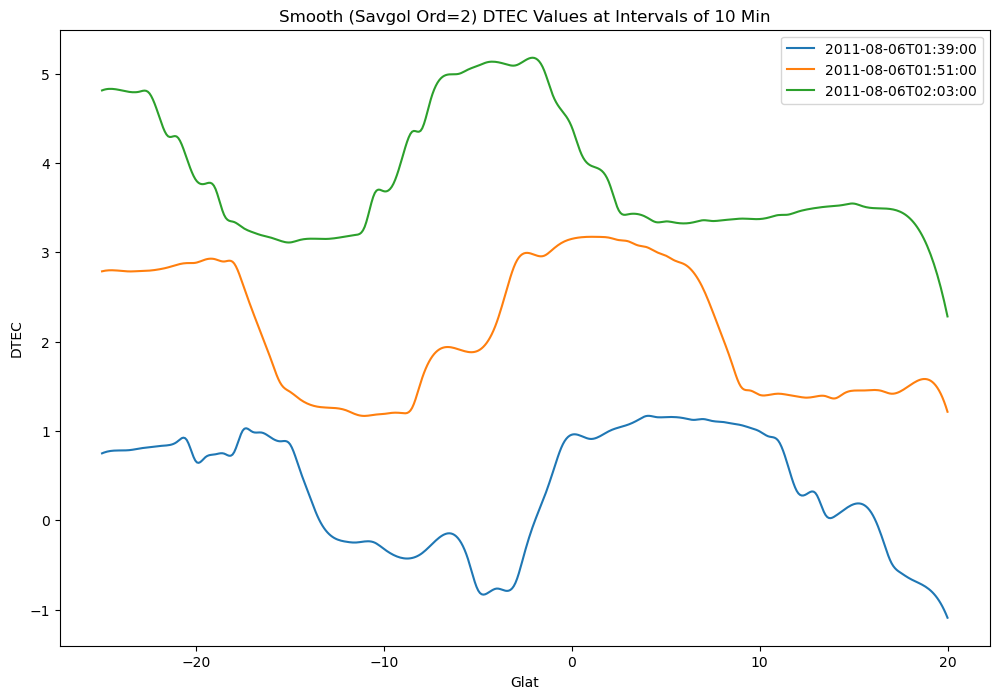

In [64]:
print(len(ds_n.Glat.values), len(np.unique(ds_n.Datetime.values)))

d = ds_n.Datetime.values[time1]
e = ds_n.Datetime.values[time2]
f = ds_n.Datetime.values[time3]
print(d,e,f)

df = ds_n.to_pandas()
df_1 = (df.iloc[np.where((ds_n.Datetime == d))].reset_index(drop=True)).sort_values('Glat', ignore_index=True)
df_2 = (df.iloc[np.where((ds_n.Datetime == e))].reset_index(drop=True)).sort_values('Glat', ignore_index=True)
df_3 = (df.iloc[np.where((ds_n.Datetime == f))].reset_index(drop=True)).sort_values('Glat', ignore_index=True)

#print(len(df1.dTEC.values), len(df2.dTEC.values), len(df3.dTEC.values)) 
lats = np.linspace(l1,l2, 500)
df1 = smoothen(df_1, lats)
df2 = smoothen(df_2, lats)
df3 = smoothen(df_3, lats)

plt.figure(figsize=(12,8))
plt.plot(df1.Glat.values, df1.dTEC.values, label = str(d)[:-10])
plt.plot(df2.Glat.values, df2.dTEC.values+2, label = str(e)[:-10])
plt.plot(df3.Glat.values, df3.dTEC.values+4, label = str(f)[:-10])
plt.title('Smooth (Savgol Ord=2) DTEC Values at Intervals of 10 Min')
plt.xlabel('Glat')
plt.ylabel('DTEC')
plt.legend()

In [58]:
def correlation(df1, df2):

    # Finding the travelling cross-correlation between two lists where the index number is x and data value is y
    # This function creates a list where each index, i, represent the cross-correlation value when i is the shift or travel 
    
    corr1 = []
    for i in range(len(df2)-10):
        l1 = len(df2)-10
        n = 0
        d1 = 0
        d2 = 0
        # u1 and u2 are the mean of the list
        u1 = np.sum(df1[i:l1])/(l1-i)
        u2 = np.sum(df2[:l1-i])/(l1-i)
        
        for j,k in zip(df1[i:l1], df2[:l1-i]):
            # i is the travelling constant which in a particular iteration shows how much shifting has been done
            n += (j-u1)*(k-u2)
            d1 += (j-u1)**2
            d2 += (k-u2)**2

        # Applying the formula for cross-correlation
        c = n/(np.sqrt(d1*d2))
        corr1.append(c)
    
    return corr1

/tmp/ipykernel_22873/3761207125.py:15: RuntimeWarning: invalid value encountered in scalar divide
  c = n/(np.sqrt(d1*d2))


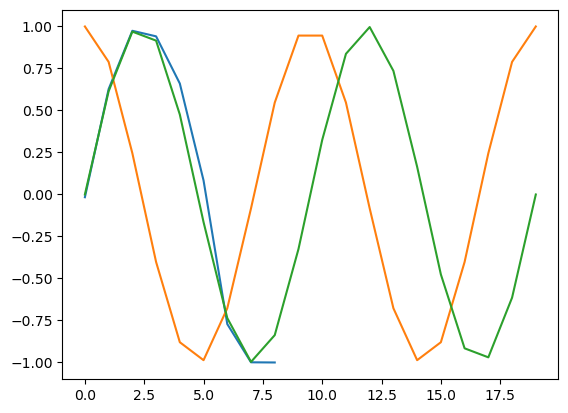

In [12]:

# Example to show the working of shifted cross-correlation function

'''
import math

in_array = np.linspace(-(2 * np.pi), 2 * np.pi, 20) 
  
cos = [] 
sin = []
for i in range(len(in_array)): 
    cos.append(math.cos(in_array[i])) 
    sin.append(math.sin(in_array[i]))
    i += 1
c = correlation(sin, cos)
plt.plot(c)
plt.plot(cos)
plt.plot(sin)
''';

/tmp/ipykernel_162197/3761207125.py:15: RuntimeWarning: invalid value encountered in scalar divide
  c = n/(np.sqrt(d1*d2))


Lat diff of peaks 1.082164328657317
Shift 1 = 3.697394789579157 glats, Shift 2 = 4.779559118236474 glats
slope 1 = 0.30811623246492975 (glat/min), Slope 2 = 0.39829659318637284 (glat/min)


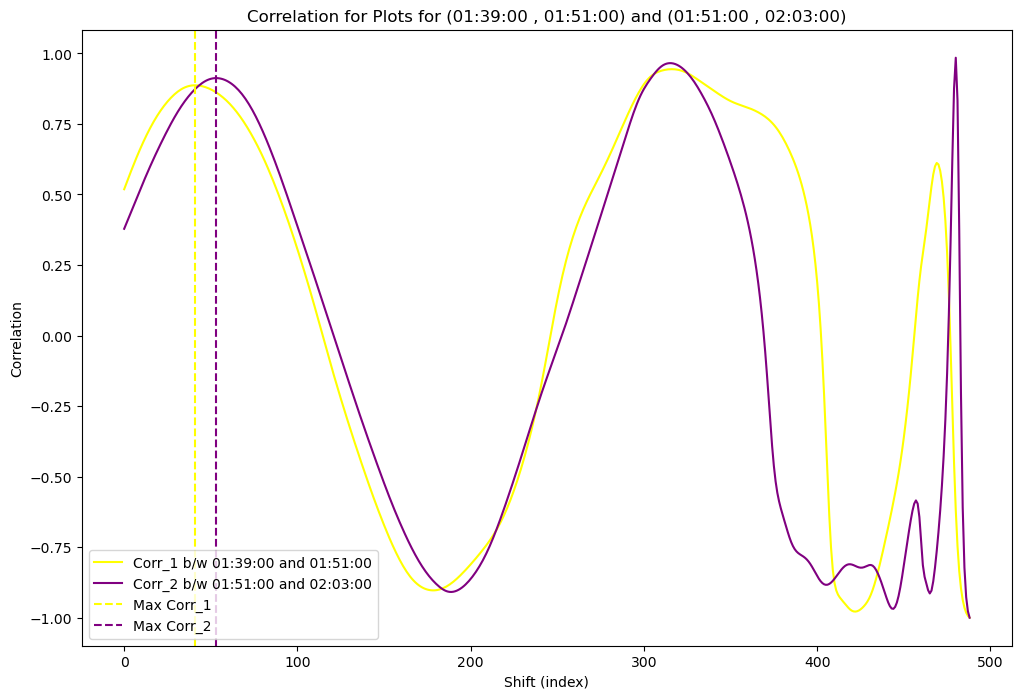

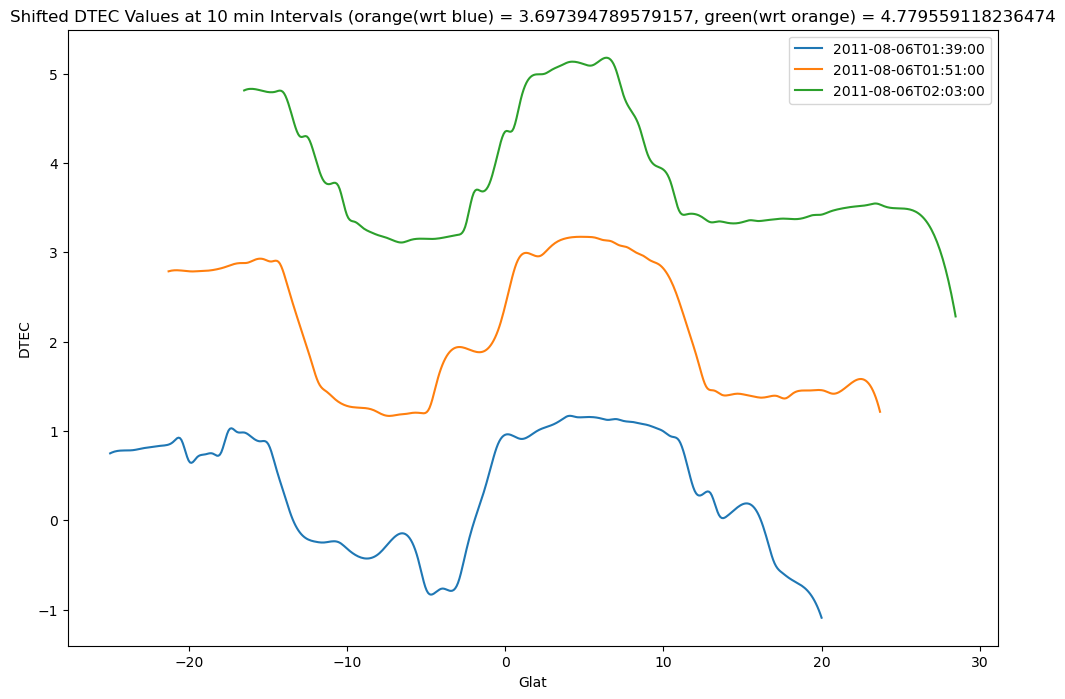

In [65]:
# corr1 and corr2 are list having all travelling cross-correlation values stored in it
# i index represent value of cross-correlation when starting and ending i values of first and second list are removed resp.
corr1 = correlation(df1.dTEC, df2.dTEC)
corr2 = correlation(df2.dTEC, df3.dTEC)

# finding points where the correlation is maximum
m1 = max(corr1[:100])
m2 = max(corr2[:100])
s1 = df2.Glat[corr1.index(m1)] - df2.Glat[0]
s2 = df3.Glat[corr2.index(m2)] - df3.Glat[0]
print('Lat diff of peaks ' + str(s2-s1))

# Calculating the velocity of TIDs (slope1 and slope2) from difference of maximum correlation points
print('Shift 1 =', s1, 'glats, Shift 2 =', s2, 'glats')
t1 = int(e-d)/(60*10**9)
slope1 = s1/t1
t2 = int(f-e)/(60*10**9)
slope2 = s2/t2
print('slope 1 =', slope1, '(glat/min), Slope 2 =', slope2, '(glat/min)')

plt.figure(figsize=(12,8))
plt.plot(corr1, label = 'Corr_1 b/w ' + str(d)[11:-10] + ' and ' + str(e)[11:-10], color = 'yellow')
plt.plot(corr2, label = 'Corr_2 b/w ' + str(e)[11:-10] + ' and ' + str(f)[11:-10], color = 'purple')
plt.ylabel('Correlation')
plt.xlabel('Shift (index)')
plt.axvline(x=corr1.index(m1), color='yellow', linestyle='--', label='Max Corr_1')
plt.axvline(x=corr2.index(m2), color='purple', linestyle='--', label='Max Corr_2')
plt.title('Correlation for Plots for (' + str(d)[11:-10] + ' , ' + str(e)[11:-10] + ') and (' + str(e)[11:-10] + ' , ' + str(f)[11:-10] + ')')
plt.legend()

plt.figure(figsize=(12,8))
plt.plot(df1.Glat.values, df1.dTEC.values, label = str(d)[:-10])
plt.plot(df2.Glat.values + s1, df2.dTEC.values+2, label = str(e)[:-10])
plt.plot(df3.Glat.values + s2 + s1, df3.dTEC.values+4, label = str(f)[:-10])
plt.title('Shifted DTEC Values at 10 min Intervals (orange(wrt blue) = ' + str(s1) + ', green(wrt orange) = ' + str(s2))
plt.xlabel('Glat')
plt.ylabel('DTEC')
plt.legend()

# Final Rewritten Code - Deriving Data from .csv or .dtec files

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import math

import cartopy.crs as ccrs
from tqdm import tqdm
import importlib as il
import datetime as dt
from scipy.interpolate import CubicSpline
from scipy.signal import find_peaks, savgol_filter

np.seterr(divide='ignore', invalid='ignore')
import sys
sys.path.append('/home/pxv220016/prasoon/data/sat_interp_repo/repo2/Cesar_LSTID_vel/')
import functions

In [39]:
path = '/home/pxv220016/prasoon/data/sat_interp_repo/repo2/Cesar_LSTID_vel/Cesar_data/'


date = ['2011-08-06', '2011-09-26', '2011-11-24', '2012-03-09', '2012-04-24', '2012-07-15', '2012-10-01', '2012-10-08', '2012-10-13', '2012-11-14', '2013-03-17', '2013-06-01', '2013-06-28']
data = []

# Below is used when file is in .DTEC format
'''
date = ['20130316', '20130317', '20130318']
data = []

for d in date:
    p = path + 'file' + d + '.dTEC'
    df = pd.read_csv(p, delim_whitespace=True, skiprows=1)
    ds = xr.Dataset.from_dataframe(df)
    print(ds)
    data.append(ds)


dates = ['2011-08-06']
for d in dates:
    p = path + d + '.csv'
    df = pd.read_csv(p)
    df['Datetime'] = pd.to_datetime(df['Datetime'])
    df.set_index('Datetime', inplace = True)
    ds = df.to_xarray()
    print(ds)
''';

# Below is used for .csv files
for d in date:
    p = path + d + '.csv'
    df = pd.read_csv(p)
    temp = xr.Dataset.from_dataframe(df)
    datetime = pd.to_datetime(temp['Datetime'].values)
    
    ds = xr.Dataset(
            {
                'Glat': (['Datetime'], temp.Glat.values),
                'dTEC': (['Datetime'], temp.dTEC.values)                
            },
        coords = {
            'Datetime' : datetime
        }
    )
    
    #print(ds)
    data.append(ds)

print(type(df.Datetime[0]))
print(data[0])

# Choosing Storm of interest
v = 12
ds = data[v]


<class 'str'>
<xarray.Dataset>
Dimensions:   (Datetime: 252357)
Coordinates:
  * Datetime  (Datetime) datetime64[ns] 2011-08-05 ... 2011-08-07T23:57:00
Data variables:
    Glat      (Datetime) float64 -44.0 23.5 -29.0 -2.0 ... -25.5 -54.0 -5.5 17.5
    dTEC      (Datetime) float64 -0.3556 -0.3778 -0.4222 ... -0.3778 -0.3333


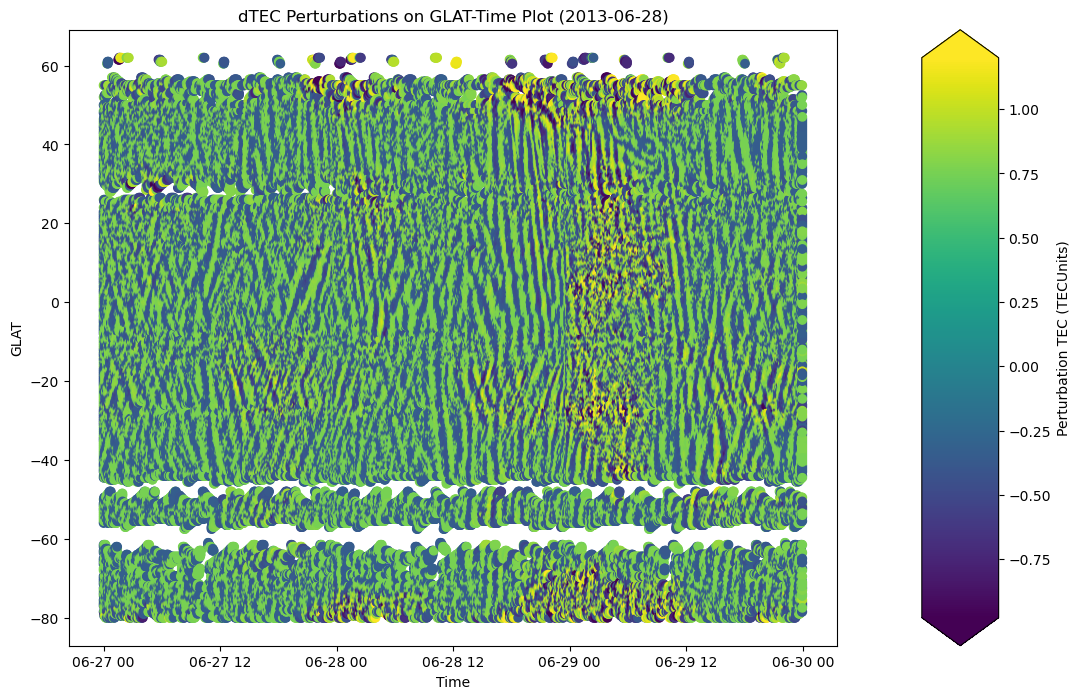

In [40]:
fig = plt.figure(figsize=(12,8))
specs = fig.add_gridspec(1, 2, width_ratios=[1,0.1])
ax = []
ax.append(fig.add_subplot(specs[0, 0]))
c = ax[0].scatter(ds.Datetime.values, ds.Glat.values, c=ds.dTEC.values)
ax[0].set_title('dTEC Perturbations on GLAT-Time Plot (' + date[v] + ')' )
ax[0].set_ylabel('GLAT')
ax[0].set_xlabel('Time')

cbar_ax = fig.add_subplot(specs[0,1])
cbar = fig.colorbar(c, cax=cbar_ax, label='Perturbation TEC (TECUnits)', extend='both')
fig.show()

Lat diff of peaks 0.0
Shift 1 = 0.0 glats, Shift 2 = 0.0 glats
slope 1 = 0.0 (glat/min), Slope 2 = 0.0 (glat/min)


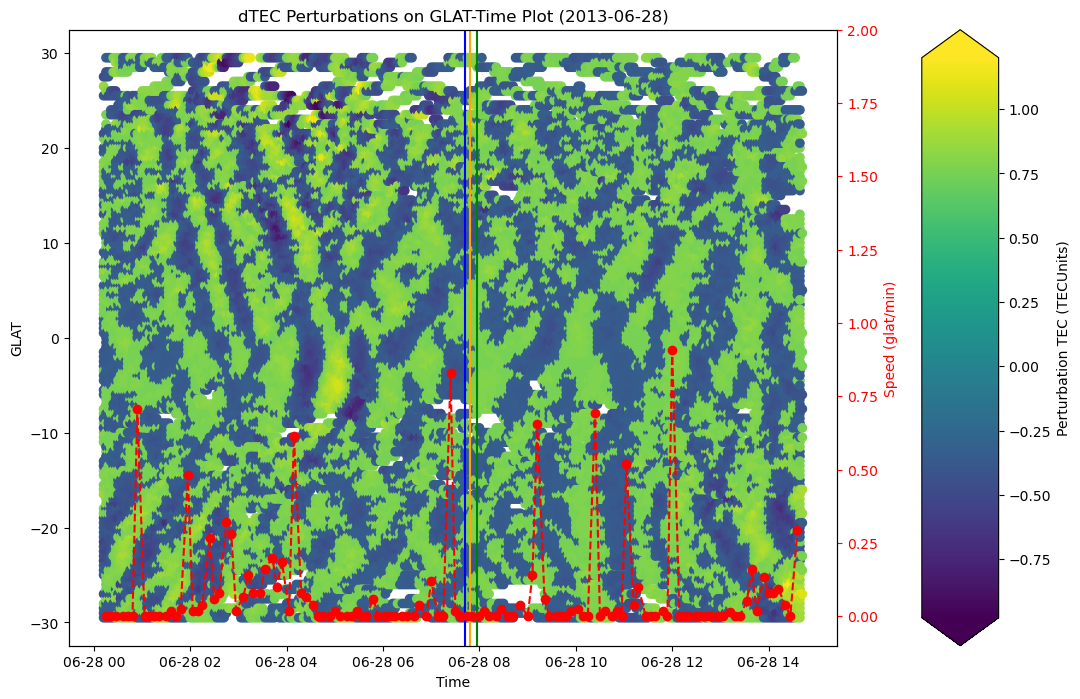

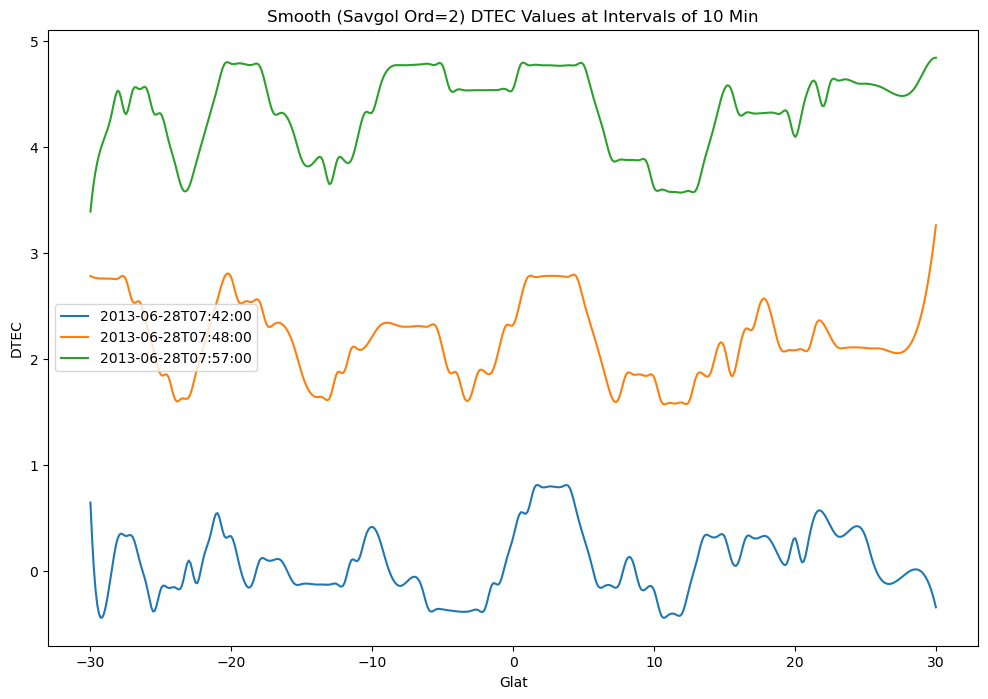

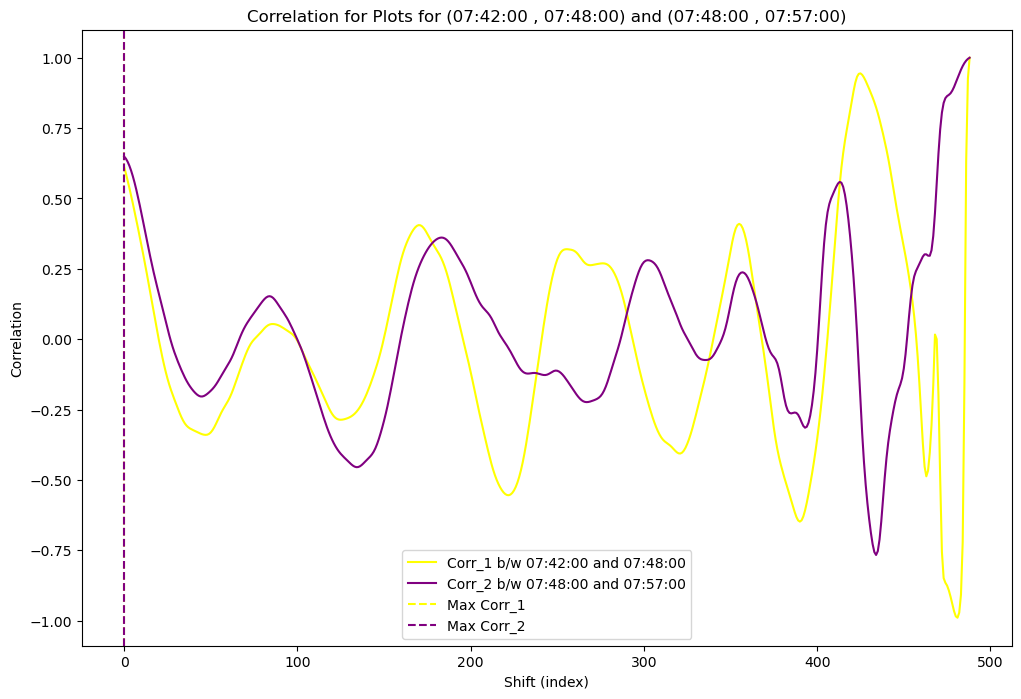

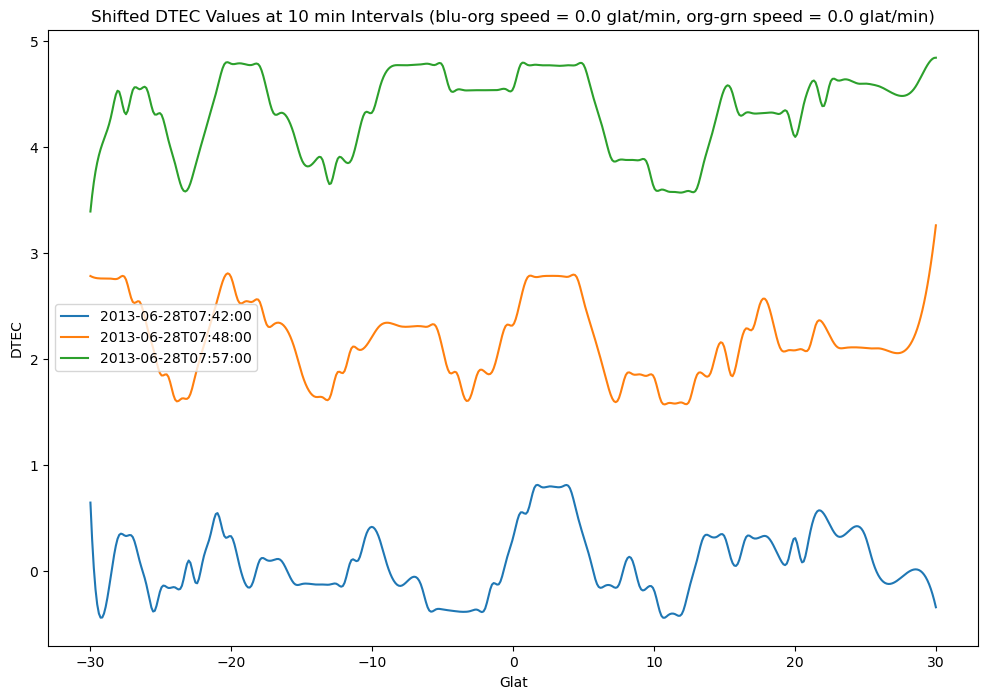

In [47]:
functions = il.reload(functions)

a = 100000
b = 160000
# Limits of latitudes
l1 = -30
l2 = 30
# index to set the time of observations
time1 = 16000
time2 = 16250
time3 = 16500

# trimming the data
ds_n = functions.ds_trim(ds, a, b, l1, l2) 

i = 0
time = [0]

# index to set the time of observations
plot_3 = True
show_speed = True

ds_n, speed, lat_shift = functions.main(ds_n, l1, l2, date[v], show_speed, plot_3, time1, time2, time3)


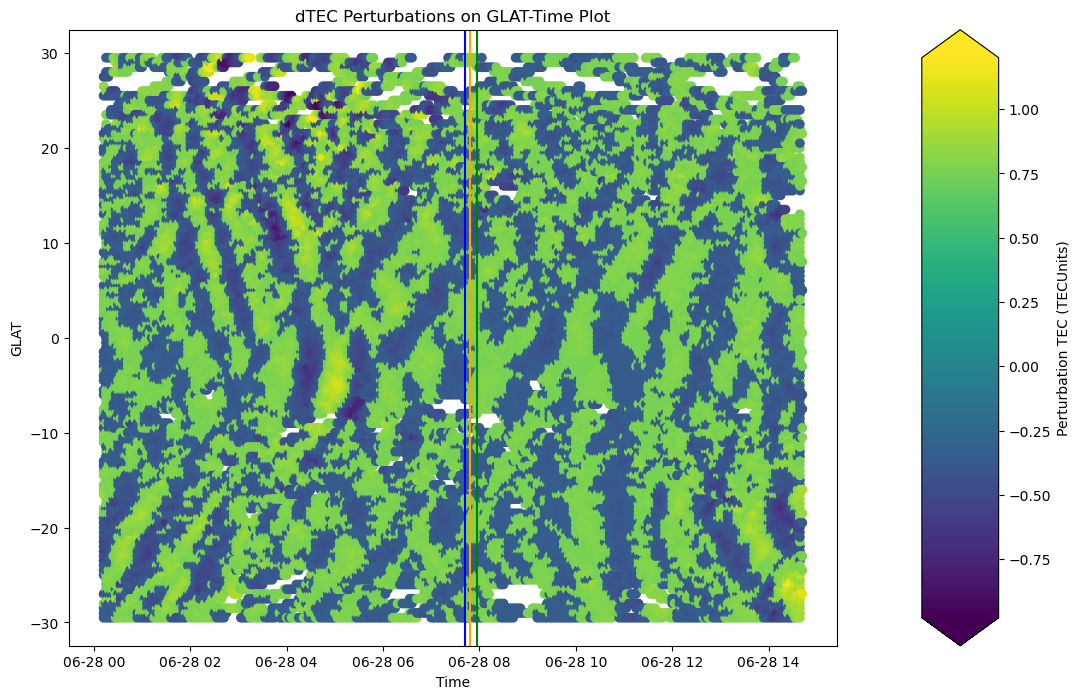

In [48]:
# Check cell to set values of a, b, l1, l2, time1, time2, time3


a = 100000
b = 160000
# Limits of latitudes
l1 = -30
l2 = 30
# index to set the time of observations
time1 = 16000
time2 = 16250
time3 = 16500

# trimming the data
ds_n = ds.isel(Datetime=slice(a,b))
ds_n = ds_n.where((ds_n.Glat > l1), drop=True)
ds_n = ds_n.where((ds_n.Glat < l2), drop=True)

#mask = [(i > -40 and i < 50) for i in ds_n.Glat.values]

fig = plt.figure(figsize=(12,8))
specs = fig.add_gridspec(1, 2, width_ratios=[1,0.1])
ax = []
ax.append(fig.add_subplot(specs[0, 0]))
ax[0].axvline(x=ds_n.Datetime.values[time1], color='blue')
ax[0].axvline(x=ds_n.Datetime.values[time2], color='orange')
ax[0].axvline(x=ds_n.Datetime.values[time3], color='green')
c = ax[0].scatter(ds_n.Datetime.values, ds_n.Glat.values, c=ds_n.dTEC.values)
ax[0].set_title('dTEC Perturbations on GLAT-Time Plot')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('GLAT')

cbar_ax = fig.add_subplot(specs[0,1])
cbar = fig.colorbar(c, cax=cbar_ax, label='Perturbation TEC (TECUnits)', extend='both')
fig.show()

# Dealing With New Storm Data
updated on 28 June 2024 by Aaron

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import os
from dateutil import parser

import cartopy.crs as ccrs
from tqdm import tqdm
import importlib as il
import datetime as dt
from scipy.interpolate import CubicSpline

import sys
sys.path.append('/home/pxv220016/prasoon/data/sat_interp_repo/repo2')
from scipy.signal import find_peaks, savgol_filter


In [51]:
# Function written by Aaron to read and store data from .dat file

def import_gps_dict(file_name, path):
    '''
            This will return us a dictionary (not dataframe) of gps data.
                keys in dataframe is the datetime of measurement,

                dict [key = datetime] [lats , lons, dtecs]
    '''
    
    try:       
        fname1 = path
        
        fname2 = path 
        
        if os.path.isfile(fname1):
            fname = fname1
            print("using newer tec values :)")


        with open(fname) as file_in:
            dates = []
            datas = []
            times = []
            is_ = -1
            for line in file_in:
                line = line.strip('\n')
                if '*' in line:
                    dates.append(line)
                    print('new date', line)
                elif 'T' in line:
                    times.append(line)
                    is_ +=1
                    datas.append([])
                else:
                    datas[is_].append(line)
        #print('length of times', len(times))
        #print(dates)

        dtimes = []
        for i in range(len(times)):
            
            l = [x for x in times[i].strip('T').strip(' ').split() if x]

            if len(dates) == 1:
                date_0 = '-'.join(dates[0].strip('*').strip(' ').split())
                date_l = parser.parse(date_0 + ' ' + ':'.join(l))
                dtimes.append(date_l)
            else:
                raise ValueError('The GPS file covers more than one day, loop over dates in dtimes')
        
        dict_ = {}
        
        for i in range(len(datas)):
            data_list_local = []
            for j in range(len(datas[i])):
                inter_ = datas[i][j].split(' ')
                inter2 = []
                for gg in inter_:
                    if len(gg) > 2:
                        inter2.append(float(gg))
                data_list_local.append(inter2)
            dict_[str(dtimes[i])] = data_list_local

        new_dict = {}
        for key in dict_.keys():
            lats = []
            lons = []
            dns = []
            for i in range(len(dict_[key])):
                lats.append(dict_[key][i][0])
                lons.append(dict_[key][i][1])
                dns.append(dict_[key][i][2])
            new_dict[key] = {'lats':lats, 'lons':lons, 'dns':dns}
        return new_dict

    except:
        print("ERROR ERROR ERROR")

In [52]:
path = '/home/pxv220016/prasoon/data/sat_interp_repo/repo2/Cesar_LSTID_vel/Cesar_data/GlobalData_new/'


date = ['Aug03-2010', 'Aug05-2011', 'Sep26-2011']
date_dt = ['2010-08-03', '2011-08-05', '2011-09-26']

data = []

# Reading the new Cesar data and storing in data list as dict
for d, d_dt in zip(date, date_dt):
    file_name = 'delta-New' + d + '.dat' 
    p = path + file_name

    # returned data is going to be in the format of dict (keys are time) whose values are also dict (keys are lat, lon, and dns).
    ds = import_gps_dict(file_name, p)
    
    #print(ds)
    data.append(ds)


using newer tec values :)
new date * 2010    8    3
using newer tec values :)
new date * 2011    8    5
using newer tec values :)
new date * 2011    9   26


In [80]:
# Storm is chosen by setting v 
v = 0

t = list(data[v].keys())
data_d = data[v] # 3 August Storm
print(date[v])

lats = [data_d[x]['lats'] for x in t]


Aug03-2010


/tmp/ipykernel_115735/2629163779.py:63: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(['-1.0', '', '', '', '0', '', '', '', '1.0'])  # Custom tick labels


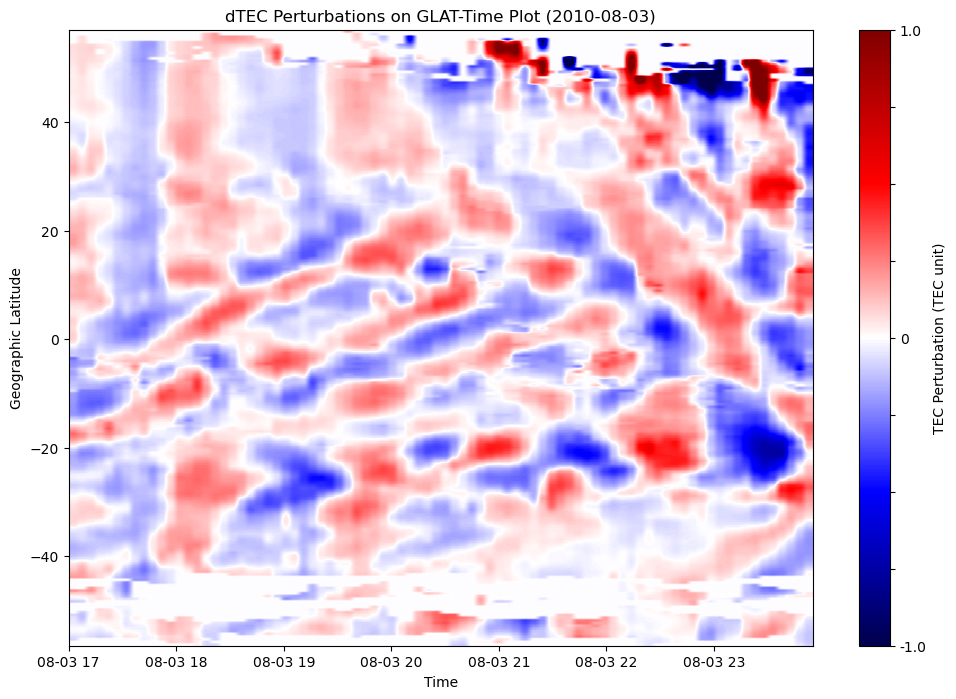

In [81]:

df = pd.DataFrame()

for i in data_d.keys():
    data_i = data_d[i]
    d = pd.DataFrame(data_i)
    
    # Choosing points of the Peruvian sector
    d = d[(d.lons > -80) & (d.lons < -70)].reset_index(drop=True)
    time_df = [parser.parse(i)]*len(d.lats)
    d['time'] = time_df

    # Processing the data to avoid nmultiple points at same lat and time values by averaging dns over the complete peruvian longitudes
    d = d.drop('lons', axis = 1)
    d = d.groupby(['lats', 'time'], as_index=False)['dns'].mean()
    d = d.sort_values(by='lats', ascending=True).reset_index(drop=True)
    df = pd.concat([df,d], ignore_index=True)

ds = xr.Dataset(
    data_vars = {
        'Glat' : (['Datetime'], df.lats),
        'dTEC' : (['Datetime'], df.dns)
    },
    coords = {
        'Datetime' : df.time
    }
)

# Choice of plotting as xr.DataSet(scatter()) or pivot_table(imshow())
repr = ['xr', '2D']
r = 1

if repr[r] == 'xr':
 
    # Plotting the xarray dataset
    fig = plt.figure(figsize=(12,8))
    specs = fig.add_gridspec(1, 2, width_ratios=[1,0.1])
    ax = []
    ax.append(fig.add_subplot(specs[0, 0]))
    c = ax[0].scatter(ds.Datetime.values, ds.Glat.values, c=ds.dTEC.values, vmax = 1, vmin = -1, extent = [min(df.time), max(df.time), min(df.lats), max(df.lats)], cmap='seismic')
    ax[0].set_title('dTEC Perturbations on GLAT-Time Plot (' + str(ds.Datetime[0].values)[:10] + ')')
    ax[0].set_ylabel('GLAT')
    ax[0].set_xlabel('Time')
    cbar_ax = fig.add_subplot(specs[0,1])
    cbar = fig.colorbar(c, cax=cbar_ax, label='Perturbation TEC (TECUnits)', extend='both')
    fig.show()
    


else:
    # Convert the dataframe into a 2D data array (lat and time as coordinates) with 0 at places of no data
    pivot_table = df.pivot(index='lats', columns='time', values='dns')
    pivot_table = pivot_table.fillna(0)  # or .fillna(np.nan) to use NaN instead of 0
    ds_a = pivot_table.values

    # Plotting the 2D array using imshow()
    fig, ax = plt.subplots(figsize=(12, 8))
    c = ax.imshow(ds_a, cmap='seismic', aspect='auto', vmin=-1, vmax=1, extent = [min(df.time), max(df.time), min(df.lats), max(df.lats)], origin = 'lower')
    ax.set_title('dTEC Perturbations on GLAT-Time Plot (' + str(df.time[0])[:10] + ')')
    ax.set_xlabel('Time')
    ax.set_ylabel('Geographic Latitude')    
    cbar = fig.colorbar(c, ax=ax, orientation='vertical')
    cbar.set_label('TEC Perturbation (TEC unit)')
    cbar.ax.set_yticklabels(['-1.0', '', '', '', '0', '', '', '', '1.0'])  # Custom tick labels
    
    plt.show()
    

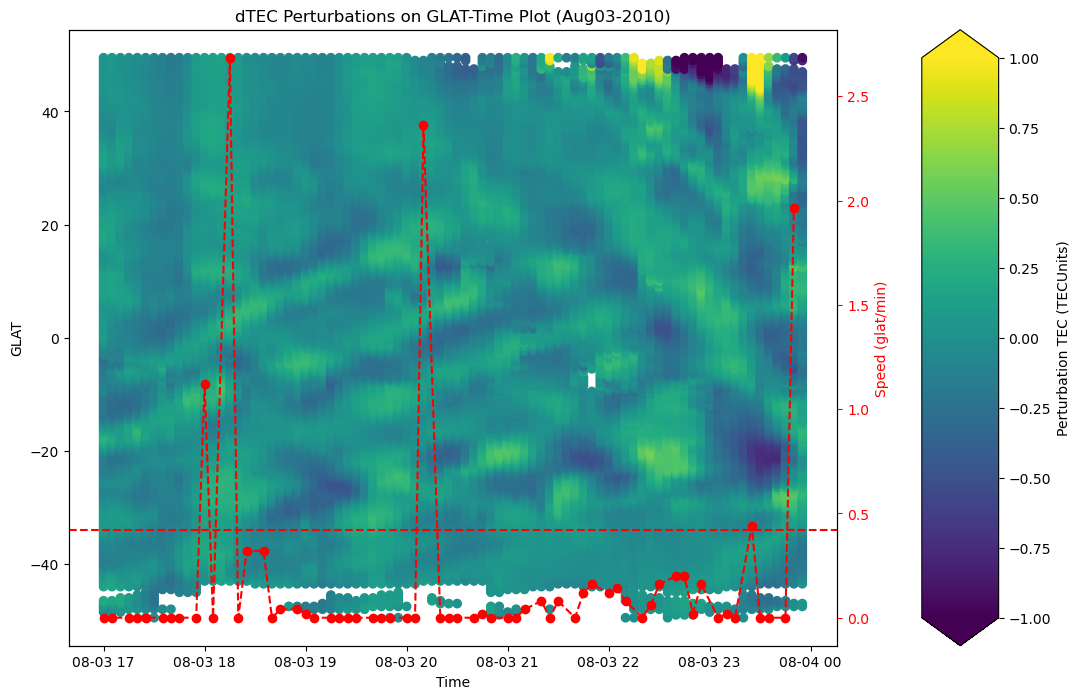

In [82]:
functions = il.reload(functions)

a = 0
b = len(ds.Glat.values)

# Limits of latitudes
l1 = -50
l2 = 50

# trimming the data
ds_n = functions.ds_trim(ds, a, b, l1, l2) 

i = 0
time = [0]

# index to set the time of observations
plot_3 = True
show_speed = True

ds_n, speed, lat_shift = functions.main(ds_n, l1, l2, date[v], show_speed, plot_3=False)
